# Packages and Function Imports

In [ ]:
pip install git+https://github.com/spaceml-org/ml4floods#egg=ml4floods

In [4]:
import traceback
import warnings

from io import StringIO
import ee
import time
import os
from glob import glob # not sure what this was used for -chris
from typing import Optional, Callable, List, Tuple
from shapely.geometry import mapping, Polygon
import numpy as np
import geopandas as gpd
import pandas as pd
import fsspec
from datetime import datetime, timezone
import math
import json

from ml4floods.data import ee_download, utils

In [15]:
def read_aoi(my_gpd_aoi:str):
    my_aoi = gpd.read_file(my_gpd_aoi)
    
    aoi_codes = my_aoi['name']
    js = json.loads(my_aoi.to_json()) # convertin gthe aoi to a json and getting the 
    
    total_bounds = ee.Geometry(ee.FeatureCollection(js).geometry())
    total_bounds_coordinates = total_bounds.getInfo()['coordinates']
    
    n_polygons = len(total_bounds_coordinates)
    
    print('Number of polygons in AOI:', n_polygons)
    
    return total_bounds, aoi_codes, n_polygons

In [32]:
def get_datetime(date_range: tuple): # function returns a tuple containing datetime
    datetime_start= datetime.strptime(date_range[0], '%d/%m/%y')
    datetime_end= datetime.strptime(date_range[1], '%d/%m/%y')
    
    start_year = datetime_start.year
    end_year = datetime_end.year
    
    #dates = (datetime_start, datetime_end)
    #years = (start_year, end_year)
    
    return datetime_start, datetime_end, start_year, end_year 

In [23]:
def get_polygon_bounds(total_bounds, aoi_codes, n_polygons):
    # Get the coordinates for each AOI.
    all_polygon_bounds = total_bounds.getInfo()['coordinates']

    # Reducing the number of AOIs to n_polygons 
    polygon_aoi_codes = aoi_codes[0:n_polygons]

    # Updating a list with the first 20 coordinates due to processing times. 
    polygon_bounds = []
    for i in range(len(all_polygon_bounds[0:n_polygons])):
      
       polygon_bounds = np.append(polygon_bounds, ee.Geometry.Polygon(all_polygon_bounds[i]))
                       
    return polygon_bounds, polygon_aoi_codes

In [35]:
def get_imageCollections(polygon_bounds: np.ndarray, dates: tuple): #bounds_list refers to a list of geometries/polygons extracted above from the aoi

    get_landsat_collection = ee_download.get_landsat_collection
    get_s2_collection = ee_download.get_s2_collection
    
    landsat_imgs = []
    s2_imgs = []
    
    for i in range(len(polygon_bounds)):
        landsat_imgs = np.append(landsat_imgs, get_landsat_collection(date_start=dates[0], date_end=dates[1] , bounds= polygon_bounds[i]))
        s2_imgs = np.append(s2_imgs, get_s2_collection(date_start=dates[0], date_end=dates[1] , bounds= polygon_bounds[i]))

    return landsat_imgs, s2_imgs

In [42]:
def properties_dataframe(landsat_imgs: ee.ImageCollection, s2_imgs: ee.ImageCollection, polygon_bounds, polygon_aoi_codes):
    
    # --------- Landsat ---------
    landsat_coordinates = [[] for _ in range(len(landsat_imgs))] # creating number of lists to match the number of polygons so that each polygon will have it's coordinates
    n_landsat = []

    # Loop 1: Getting the number of images for each AOI, returns an array where each index is an 
    # AOI and each value in the index is the number of images of that AOI. 
    for i in range(len(landsat_imgs)):

        # Get the coordinates for each AOI
        landsat_coordinates[i] = polygon_bounds[i]['coordinates']

        # Of the 20 indices, there will be the number of images in each. 
        n_landsat = np.append(n_landsat, len(landsat_imgs[i].getInfo()['features']))

    # End loop 1

    id_list = []
    cloudCover_list = []
    validPixels_list = []
    source_list = ['landsat']*np.int(n_landsat.sum()) # creating a list the size of the total number of images of all the polygons
    coordinates_list = [] # creating number of lists to match the number of polygons so that each polygon will have it's coordinates
    aoi_list = []

    # Loop 2: Updating property lists that will be used to populate a dataframe.
    for i in range(len(landsat_imgs)): # Iterating through all the polygons

        for k in range(np.int(n_landsat[i])): # Iterating through all the images of each polygon

            id_list = np.append(id_list, landsat_imgs[i].getInfo()['features'][k].get('id'))
            cloudCover_list = np.append(cloudCover_list, landsat_imgs[i].getInfo()['features'][k].get('properties')['CLOUD_COVER'])
            validPixels_list = np.append(validPixels_list, landsat_imgs[i].getInfo()['features'][k].get('properties')['valids'])
            aoi_list = np.append(aoi_list, polygon_aoi_codes[i])
            index_coord = landsat_coordinates[i]
            coordinates_list.extend(index_coord)      
    # End loop 2

    # Populate the dataframe
    landsat_df = gpd.GeoDataFrame({'id':id_list, 'cloud_cvr':cloudCover_list, 'source': source_list, 'aoi_code': aoi_list, 'valid_pxls': validPixels_list, 'geometry':coordinates_list})
    landsat_df.head(10)
    print('Number of landsat images:', len(landsat_df))

    # --------- S2 ---------
    s2_coordinates = [[] for _ in range(len(s2_imgs))] # creating number of lists to match the number of polygons so that each polygon will have it's coordinates
    n_s2 = []
    # Loop 1
    for i in range(len(s2_imgs)): # Iterating through all the polygons

        s2_coordinates[i] = polygon_bounds[i]['coordinates']

        n_s2 = np.append(n_s2, len(s2_imgs[i].getInfo()['features'])) # Of the 20 indices, there will be the number of images in each. 
    # End loop 1

    id_list = []
    cloudCover_list = []
    validPixels_list = []
    source_list = ['s2']*np.int(n_s2.sum()) # creating a list the size of the total number of images of all the polygons
    coordinates_list = [] # creating number of lists to match the number of polygons so that each polygon will have it's coordinates
    aoi_list = []

    # Loop 2
    for i in range(len(s2_imgs)): # Iterating through all the polygons

        for k in range(np.int(n_s2[i])): # Iterating through all the images of each polygon

            id_list = np.append(id_list, s2_imgs[i].getInfo()['features'][k].get('id'))
            cloudCover_list = np.append(cloudCover_list, s2_imgs[i].getInfo()['features'][k].get('properties')['CLOUDY_PIXEL_PERCENTAGE'])
            validPixels_list = np.append(validPixels_list, s2_imgs[i].getInfo()['features'][k].get('properties')['valids'])
            aoi_list = np.append(aoi_list, polygon_aoi_codes[i])
            index_coord = s2_coordinates[i]
            coordinates_list.extend(index_coord)      
    # End loop 2

    # Populate the dataframe
    s2_df = gpd.GeoDataFrame({'id':id_list, 'cloud_cvr':cloudCover_list, 'source': source_list, 'aoi_code': aoi_list, 'valid_pxls': validPixels_list, 'geometry':coordinates_list})
    s2_df.head(10)
    print('Number of s2 images:', len(s2_df))
    
    # Combining into one dataframe, assigning crs and formatting geometry column for plotting
    
    all_df = pd.concat([landsat_df, s2_df])
    
    all_df.crs = 'EPSG:4326'
    
    all_df['geometry'] = all_df['geometry'].apply(Polygon)
    
    print('Total number of images:', len(all_df))
          
    return all_df

# Workflow Execution for NEMA AOIS from 22/09/22 to 10/10/22

In [10]:
ee.Authenticate()

Enter verification code:  4/1ARtbsJoGm-5PwnSEQe9QABdIkLn7AH22VC_JWxcf5J2RL4HQfiAQxchZwqU



Successfully saved authorization token.


In [11]:
ee.Initialize()

In [19]:
NEMA_aois, NEMA_aoi_codes, NEMA_n_polygons = read_aoi('NEMA_aois.geojson')

Number of polygons in AOI: 262


In [20]:
NEMA_aoi_codes

0      GRID06946
1      GRID06947
2      GRID06948
3      GRID06949
4      GRID06950
         ...    
279    GRID11960
280    GRID11961
281    GRID12106
282    GRID12107
283    GRID12108
Name: name, Length: 284, dtype: object

In [33]:
date_range = ('22/09/22', '10/10/22')

NEMA_dates = get_datetime(date_range)

In [34]:
NEMA_dates

(datetime.datetime(2022, 9, 22, 0, 0),
 datetime.datetime(2022, 10, 10, 0, 0),
 2022,
 2022)

In [24]:
NEMA_polys, NEMA_poly_aois = get_polygon_bounds(NEMA_aois, NEMA_aoi_codes, NEMA_n_polygons)

In [39]:
NEMA_poly_landsat, NEMA_poly_s2 = get_imageCollections(NEMA_polys, NEMA_dates)

In [45]:
NEMA_df = properties_dataframe(NEMA_poly_landsat, NEMA_poly_s2, NEMA_polys, NEMA_poly_aois)

Number of landsat images: 559
Number of s2 images: 1308
Total number of images: 1867


In [74]:
NEMA_df

,id,cloud_cvr,source,aoi_code,valid_pxls,geometry
0,2022-09-24,3.290000,landsat,GRID06946,1.000000,"POLYGON ((146.26329 -32.10516, 146.47329 -32.1..."
1,2022-09-25,0.630000,landsat,GRID06946,0.256705,"POLYGON ((146.26329 -32.10516, 146.47329 -32.1..."
2,2022-10-02,0.050000,landsat,GRID06946,1.000000,"POLYGON ((146.26329 -32.10516, 146.47329 -32.1..."
3,2022-09-24,3.290000,landsat,GRID06947,1.000000,"POLYGON ((146.26329 -31.90516, 146.47329 -31.9..."
4,2022-09-25,0.630000,landsat,GRID06947,0.029889,"POLYGON ((146.26329 -31.90516, 146.47329 -31.9..."
...,...,...,...,...,...,...
1303,2022-10-08,28.806324,s2,GRID10472,1.000000,"POLYGON ((153.26329 -28.90516, 153.47329 -28.9..."
1304,2022-09-23,87.276658,s2,GRID10473,1.000000,"POLYGON ((153.26329 -28.70516, 153.47329 -28.7..."
1305,2022-09-28,52.410792,s2,GRID10473,1.000000,"POLYGON ((153.26329 -28.70516, 153.47329 -28.7..."
1306,2022-10-03,59.028069,s2,GRID10473,1.000000,"POLYGON ((153.26329 -28.70516, 153.47329 -28.7..."


In [91]:
NEMA_df.explore(tooltip = 'aoi_code', column= 'cloud_cvr', popup= True, style_kwds= dict(color= 'black'))

In [217]:
NEMA_df_filtered = NEMA_df[(NEMA_df['cloud_cvr'] < 5) & (NEMA_df['valid_pxls'] > 0.20)]

In [218]:
NEMA_df_filtered

,id,cloud_cvr,source,aoi_code,valid_pxls,geometry
0,2022-09-24,3.290000,landsat,GRID06946,1.000000,"POLYGON ((146.26329 -32.10516, 146.47329 -32.1..."
1,2022-09-25,0.630000,landsat,GRID06946,0.256705,"POLYGON ((146.26329 -32.10516, 146.47329 -32.1..."
2,2022-10-02,0.050000,landsat,GRID06946,1.000000,"POLYGON ((146.26329 -32.10516, 146.47329 -32.1..."
3,2022-09-24,3.290000,landsat,GRID06947,1.000000,"POLYGON ((146.26329 -31.90516, 146.47329 -31.9..."
5,2022-10-02,0.050000,landsat,GRID06947,1.000000,"POLYGON ((146.26329 -31.90516, 146.47329 -31.9..."
...,...,...,...,...,...,...
984,2022-09-29,2.167529,s2,GRID09455,1.000000,"POLYGON ((149.86329 -30.30516, 150.07329 -30.3..."
991,2022-09-29,2.167529,s2,GRID09456,1.000000,"POLYGON ((149.86329 -30.10516, 150.07329 -30.1..."
1029,2022-09-29,2.167529,s2,GRID09599,0.849287,"POLYGON ((150.06329 -30.50516, 150.27329 -30.5..."
1036,2022-09-29,2.167529,s2,GRID09600,0.997373,"POLYGON ((150.06329 -30.30516, 150.27329 -30.3..."


In [219]:
_aoi_list = NEMA_df.groupby(['aoi_code'])
_aoi_list.count()['id']

aoi_code
GRID06946     7
GRID06947     7
GRID06948     6
GRID06949     6
GRID06950     6
             ..
GRID10469     8
GRID10470    16
GRID10471     6
GRID10472     6
GRID10473     5
Name: id, Length: 240, dtype: int64

In [220]:
NEMA_df.to_file('NEMA_df.shp')

In [221]:
filtered_aoi_list = NEMA_df_filtered.groupby(['aoi_code'])

In [233]:
NEMA_img_per_aoi = NEMA_df_filtered.groupby(['aoi_code']).count()['id']

In [234]:
NEMA_img_per_aoi

aoi_code
GRID06946    4
GRID06947    3
GRID06948    3
GRID06949    3
GRID06950    3
            ..
GRID09455    1
GRID09456    1
GRID09599    1
GRID09600    1
GRID10471    1
Name: id, Length: 160, dtype: int64

In [235]:
NEMA_img_per_aoi.mean()

3.28125

In [174]:
NEMA_df_filtered.explore(tooltip = 'aoi_code', column= 'cloud_cvr', popup= True, style_kwds= dict(color= 'black'))

Text(0, 0.5, 'Number of Images')

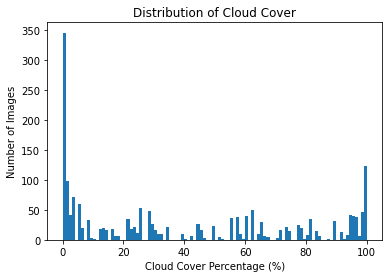

In [254]:
cloud_cvr_hist = NEMA_df['cloud_cvr'].plot.hist(bins=100, title='Distribution of Cloud Cover')
cloud_cvr_hist.set_xlabel("Cloud Cover Percentage (%)")
cloud_cvr_hist.set_ylabel("Number of Images")


Text(0, 0.5, 'Number of Images (log)')

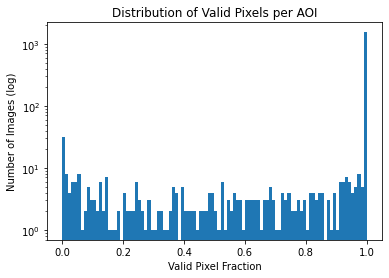

In [249]:
valid_pxl_hist = NEMA_df['valid_pxls'].plot.hist(bins=100, logy=True, title='Distribution of Valid Pixels per AOI')

valid_pxl_hist.set_xlabel("Valid Pixel Fraction")
valid_pxl_hist.set_ylabel("Number of Images (log)")

Text(7, 37, 'Mean images per AOI = 3.28125')

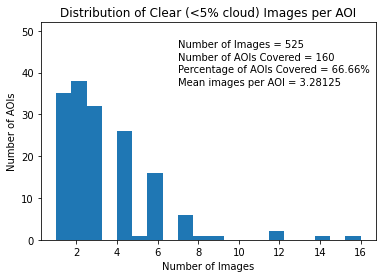

In [ ]:
clear_img_plot_5 = NEMA_img_per_aoi.plot.hist(ylim = (0, 52), bins=20, title='Distribution of Clear (<5% cloud) Images per AOI')
clear_img_plot_5.set_xlabel('Number of Images')
clear_img_plot_5.set_ylabel('Number of AOIs') 
clear_img_plot_5.text(7, 46, 'Number of Images = 525')
clear_img_plot_5.text(7, 43, 'Number of AOIs Covered = 160')
clear_img_plot_5.text(7, 40, 'Percentage of AOIs Covered = 66.66%')
clear_img_plot_5.text(7, 37, 'Mean images per AOI = 3.28125')


In [225]:
NEMA_df_filtered10 = NEMA_df[(NEMA_df['cloud_cvr'] < 10) & (NEMA_df['valid_pxls'] > 0.20)]

In [226]:
NEMA_df_filtered10.explore(tooltip = 'aoi_code', column= 'cloud_cvr', popup= True, style_kwds= dict(color= 'black'))

In [255]:
NEMA_df_filtered10

,id,cloud_cvr,source,aoi_code,valid_pxls,geometry
0,2022-09-24,3.290000,landsat,GRID06946,1.000000,"POLYGON ((146.26329 -32.10516, 146.47329 -32.1..."
1,2022-09-25,0.630000,landsat,GRID06946,0.256705,"POLYGON ((146.26329 -32.10516, 146.47329 -32.1..."
2,2022-10-02,0.050000,landsat,GRID06946,1.000000,"POLYGON ((146.26329 -32.10516, 146.47329 -32.1..."
3,2022-09-24,3.290000,landsat,GRID06947,1.000000,"POLYGON ((146.26329 -31.90516, 146.47329 -31.9..."
5,2022-10-02,0.050000,landsat,GRID06947,1.000000,"POLYGON ((146.26329 -31.90516, 146.47329 -31.9..."
...,...,...,...,...,...,...
1022,2022-09-29,6.908821,s2,GRID09598,0.609050,"POLYGON ((150.06329 -30.70516, 150.27329 -30.7..."
1026,2022-10-09,8.091850,s2,GRID09598,0.620115,"POLYGON ((150.06329 -30.70516, 150.27329 -30.7..."
1029,2022-09-29,2.167529,s2,GRID09599,0.849287,"POLYGON ((150.06329 -30.50516, 150.27329 -30.5..."
1036,2022-09-29,2.167529,s2,GRID09600,0.997373,"POLYGON ((150.06329 -30.30516, 150.27329 -30.3..."


In [230]:
NEMA_img_per_aoi10 = NEMA_df_filtered10.groupby(['aoi_code']).count()['id']

In [231]:
NEMA_img_per_aoi10

aoi_code
GRID06946    4
GRID06947    3
GRID06948    3
GRID06949    3
GRID06950    3
            ..
GRID10334    1
GRID10335    1
GRID10336    1
GRID10468    1
GRID10471    1
Name: id, Length: 201, dtype: int64

In [232]:
NEMA_img_per_aoi10.mean()

3.1393034825870645

Text(7, 37, 'Mean images per AOI = 3.139')

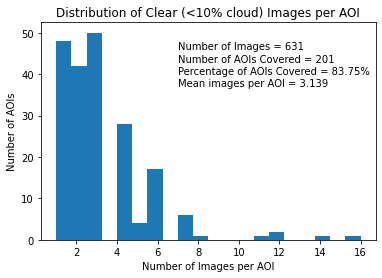

In [258]:
clear_img_plot_10 = NEMA_img_per_aoi10.plot.hist(bins=20, title='Distribution of Clear (<10% cloud) Images per AOI')
clear_img_plot_10.set_xlabel('Number of Images per AOI')
clear_img_plot_10.set_ylabel('Number of AOIs') 
clear_img_plot_10.text(7, 46, 'Number of Images = 631')
clear_img_plot_10.text(7, 43, 'Number of AOIs Covered = 201')
clear_img_plot_10.text(7, 40, 'Percentage of AOIs Covered = 83.75%')
clear_img_plot_10.text(7, 37, 'Mean images per AOI = 3.139')
